In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd

### Load all the data for each subject

In [70]:
path = "../USC-HAD/"
activity = []
activity_num = []
sensor_reading = []
subject_num = []
for root, directories, files in os.walk(path,topdown=True): ### directories = "Subject2" e.g
    for name in files:
        if ".mat" in name:
            mat = loadmat(os.path.join(root,name))
            activity.append(mat["activity"][0])
            sensor_reading.append(mat["sensor_readings"])
            subject.extend(mat["subject"])
            if mat.get("activity_number") is None:
                activity_num.append("99")
            else:
                activity_num.append(mat["activity_number"][0])
            

In [167]:
sensor_reading[0]

array([[-0.65369838,  0.80597609, -0.15303452,  0.29196018, -0.02742146,
        -0.91044861],
       [-0.65713215,  0.80597609, -0.14937437,  0.69259858, -0.42889506,
        -0.50602061],
       [-0.65369838,  0.80959523, -0.15303452,  0.28885165,  0.37557945,
        -0.5044297 ],
       ...,
       [-0.65369838,  0.80959523, -0.14205407,  0.0721088 , -0.02077455,
        -0.54122412],
       [-0.65369838,  0.80959523, -0.14205407,  0.07188113, -0.02070895,
        -0.53954232],
       [-0.65369838,  0.80959523, -0.14205407,  0.07165418, -0.02064357,
        -0.53786564]])

In [166]:
for i in range(len(sensor_reading)):
    print(len(sensor_reading[i]))

5000
2000
2000
5000
2527
2444
3311
2000
5000
5000
2000
1548
2000
5000
2385
2155
2000
1500
2201
2000
1840
2000
2400
1717
2000
1600
4500
4100
3900
3900
1300
2600
2500
4400
1300
4600
3100
2600
3000
4800
1400
2500
2400
3100
1400
1900
1600
4800
4000
5100
1900
4200
3000
1800
1700
2700
3100
2800
4800
2700
5000
2000
2000
5000
2329
2493
2294
2000
5000
5000
2000
2434
2000
5000
2513
2285
2000
2000
2304
2000
2775
2000
1891
2462
2000
1400
900
3600
4000
800
600
2600
2600
800
600
800
3400
2900
3100
800
700
2600
2600
3600
800
1800
1800
1300
3800
1500
1800
700
3600
1700
1800
3400
3700
900
800
3300
5000
5000
5000
5000
3571
2737
2841
5000
5000
5000
5000
3364
5000
5000
3339
3141
4000
5000
3003
6000
2813
6000
2838
2840
5000
2800
2200
4900
5000
2400
2100
13500
13500
2500
3100
2100
4500
13400
4600
2100
2500
13000
13000
3800
2900
1800
1900
2600
5600
2700
1700
2700
5600
1900
1700
5000
5400
2500
2400
5300
5000
4000
4000
5000
2193
2084
2542
4000
5000
5000
4000
2618
4000
5000
2526
2489
4000
4000
2208
4000
2567
40

In [150]:
print(len(activity_num))

840


In [74]:
acc_x = []
acc_y = []
acc_z = []
gyro_x = []
gyro_y = []
gyro_z = []
subjects = []
labels = []
for i in range(len(sensor_reading)): ### for each reading in total reading
    for readings in sensor_reading[i]:
        acc_x.append(readings[0])
        acc_y.append(readings[1])
        acc_z.append(readings[2])
        gyro_x.append(readings[3])
        gyro_y.append(readings[4])
        gyro_z.append(readings[5])
        subjects.append(subject[i])
        labels.append(activity_num[i])

In [64]:
set(activity)

{'elevator-down',
 'elevator-up',
 'jump',
 'jumping',
 'run',
 'running',
 'sit',
 'sitting',
 'sleeping',
 'stand',
 'standing',
 'walk-downstairs',
 'walk-forward',
 'walk-left',
 'walk-right',
 'walk-up',
 'walk-upstairs',
 'walking-down',
 'walking-downstairs',
 'walking-forward',
 'walking-left',
 'walking-right',
 'walking-up',
 'walking-upstairs'}

### Create Dataframe

In [75]:
df = pd.DataFrame({"Subject_Id":subjects,"acc_x":acc_x,"acc_y":acc_y,"acc_z":acc_z,
                  "gyro_x":gyro_x,"gyro_y":gyro_y,"gyro_z":gyro_z,"labels":labels})

In [174]:
len(df)

2811490

In [76]:
df.head()

,Subject_Id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,labels
0,2,-0.653698,0.805976,-0.153035,0.291960,-0.027421,-0.910449,10
1,2,-0.657132,0.805976,-0.149374,0.692599,-0.428895,-0.506021,10
2,2,-0.653698,0.809595,-0.153035,0.288852,0.375579,-0.504430,10
3,2,-0.650265,0.809595,-0.149374,0.287940,0.374394,-0.101278,10
4,2,-0.646831,0.805976,-0.149374,0.287031,0.373212,-0.502525,10


In [171]:
df1 = df[(df.labels != "99")]

In [176]:
df1.head()

,Subject_Id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,labels
0,2,-0.653698,0.805976,-0.153035,0.291960,-0.027421,-0.910449,10
1,2,-0.657132,0.805976,-0.149374,0.692599,-0.428895,-0.506021,10
2,2,-0.653698,0.809595,-0.153035,0.288852,0.375579,-0.504430,10
3,2,-0.650265,0.809595,-0.149374,0.287940,0.374394,-0.101278,10
4,2,-0.646831,0.805976,-0.149374,0.287031,0.373212,-0.502525,10


In [172]:
len(df1)

2809281

In [95]:
no_labels = df[(df.labels=="99")]

In [173]:
len(no_labels)

2209

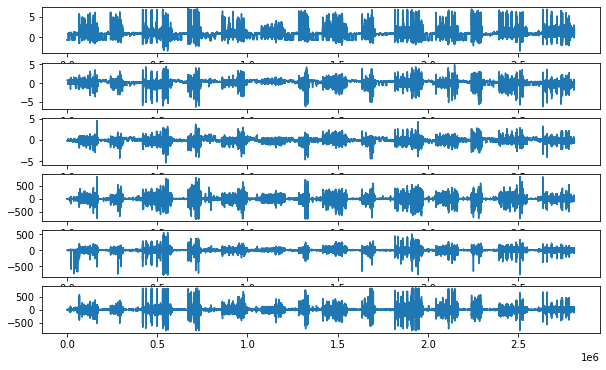

In [177]:
plt.figure(figsize=(10,6))
plt.subplot(6,1,1)
plt.plot(df1["acc_x"])
plt.subplot(6,1,2)
plt.plot(df1["acc_y"])
plt.subplot(6,1,3)
plt.plot(df1["acc_z"])
plt.subplot(6,1,4)
plt.plot(df1["gyro_x"])
plt.subplot(6,1,5)
plt.plot(df1["gyro_y"])
plt.subplot(6,1,6)
plt.plot(df1["gyro_z"])
plt.show()

### Signal Segmentation

In [ ]:
### 68 number of samples in each timestep window size = 50%

In [203]:
def window(data,window_size):
    start = 0
    while start < data.count():
        yield int(start),int(start+window_size)
        start += (window_size/2)

In [ ]:
def signal_segmentation(data,window_size):
    segment = np.empty((0,6,window_size))
    

### Jiang and Yin's algorithm

In [205]:
raw_signal = [acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z]

In [207]:
def alg_2(raw_signal): ### input:raw signal list (6xNumber of sample point)
    Ns = len(raw_signal)
    sis = []
    signal_images = []
    for i in range(1,Ns+1):
        sis.append(i)
        signal_images.append(raw_signal[i-1])
    i = Ns
    j = i + 1
    Nsis = len(sis)
    while (i != j):
        inter_sis = list(zip(sis, sis[1:] + sis[:0]))
        if j > (Ns):
            j = 1
        elif (i,j) not in inter_sis and (j,i) not in inter_sis:
            sis.append(j)
            signal_images.append(raw_signal[j-1])
            Nsis += 1
            i = j
            j = i + 1
        else:
            j = j+1
    print("SIS:",sis,"NSIS:",Nsis,"(i,j):",(i,j))
    return signal_images

In [208]:
stack_raw_signal = alg_2(raw_signal)

SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)


In [209]:
len(stack_raw_signal)

14

In [210]:
stack_raw_signal_array = np.array(stack_raw_signal[0])
for i in range(1,len(stack_raw_signal)):
    stack_raw_signal_array = np.vstack((stack_raw_signal_array,stack_raw_signal[i]))

In [211]:
stack_raw_signal_array.shape

(14, 2811490)

In [356]:
aa = stack_raw_signal_array[:,100:200]

In [357]:
aa.shape

(14, 100)

In [235]:
def plot_SI(SI):
    plt.figure(figsize=(10,6))
    n,off = SI.shape[0],0
    for i in range(n):
        plt.subplot(n,1,off+1)
        plt.plot(SI[off,:])
        plt.title(str(i), y=0, loc='left')
        off += 1
    plt.show()

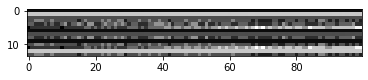

In [358]:
plt.imshow(aa,cmap="gray")

### DFT

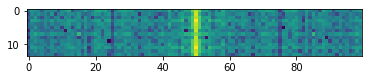

In [359]:
SI_fft = np.fft.fft2(aa)
fshift_SI = np.fft.fftshift(SI_fft)
magnitude_spectrum_SI = np.log(np.abs(fshift_SI))
plt.imshow(magnitude_spectrum_SI)
plt.show()

### Plot for different activity

In [250]:
act_1 = df1[df1.labels=="1"]
act_8 = df1[df1.labels=="8"]
act_10 = df1[df1.labels=="10"]

In [288]:
raw_signal_act_1 = np.array([act_1.acc_x.values,act_1.acc_y.values,act_1.acc_z.values,
                    act_1.gyro_x.values,act_1.gyro_y.values,act_1.gyro_z.values])
raw_signal_act_8 = np.array([act_8.acc_x.values,act_8.acc_y.values,act_8.acc_z.values,
                    act_8.gyro_x.values,act_8.gyro_y.values,act_8.gyro_z.values])
raw_signal_act_10= np.array([act_10.acc_x.values,act_10.acc_y.values,act_10.acc_z.values,
                    act_10.gyro_x.values,act_10.gyro_y.values,act_10.gyro_z.values])

In [289]:
raw_signal_act_1_stacked = alg_2(raw_signal_act_1)
raw_signal_act_8_stacked = alg_2(raw_signal_act_8)
raw_signal_act_10_stacked = alg_2(raw_signal_act_10)

SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)
SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)
SIS: [1, 2, 3, 4, 5, 6, 1, 3, 5, 1, 4, 6, 2, 4] NSIS: 14 (i,j): (4, 4)


In [290]:
stack_raw_signal_act_1 = np.array(raw_signal_act_1_stacked[0])
for i in range(1,len(raw_signal_act_1_stacked)):
    stack_raw_signal_act_1 = np.vstack((stack_raw_signal_act_1,raw_signal_act_1_stacked[i]))

In [291]:
stack_raw_signal_act_8 = np.array(raw_signal_act_8_stacked[0])
for i in range(1,len(raw_signal_act_8_stacked)):
    stack_raw_signal_act_8 = np.vstack((stack_raw_signal_act_8,raw_signal_act_8_stacked[i]))

In [292]:
stack_raw_signal_act_10 = np.array(raw_signal_act_10_stacked[0])
for i in range(1,len(raw_signal_act_10_stacked)):
    stack_raw_signal_act_10 = np.vstack((stack_raw_signal_act_10,raw_signal_act_10_stacked[i]))

In [338]:
stack_raw_signal_act_1_sub = stack_raw_signal_act_1[:,0:100]
stack_raw_signal_act_8_sub = stack_raw_signal_act_8[:,0:100]
stack_raw_signal_act_10_sub = stack_raw_signal_act_10[:,0:100]

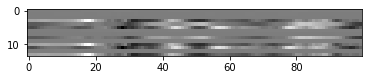

In [339]:
plt.imshow(stack_raw_signal_act_1_sub,cmap="gray")

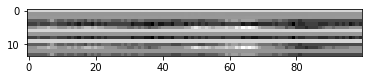

In [340]:
plt.imshow(stack_raw_signal_act_8_sub,cmap="gray")

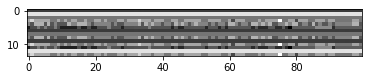

In [341]:
plt.imshow(stack_raw_signal_act_10_sub,cmap="gray")

### DFT

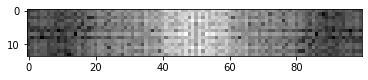

In [360]:
SI_fft_act_1 = np.fft.fft2(stack_raw_signal_act_1_sub) ###walking
fshift = np.fft.fftshift(SI_fft_act_1)
magnitude_spectrum = np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum,cmap="gray")
plt.show()

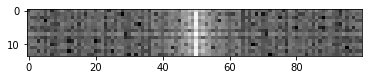

In [361]:
SI_fft_act_8 = np.fft.fft2(stack_raw_signal_act_8_sub) ###sitting
fshift_8 = np.fft.fftshift(SI_fft_act_8)
magnitude_spectrum_8 = np.log(np.abs(fshift_8))
plt.imshow(magnitude_spectrum_8,cmap="gray")
plt.show()

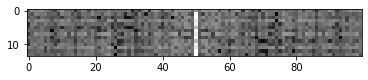

In [362]:
SI_fft_act_10 = np.fft.fft2(stack_raw_signal_act_10_sub) ###sleeping
fshift_10 = np.fft.fftshift(SI_fft_act_10)
magnitude_spectrum_10 = np.log(np.abs(fshift_10))
plt.imshow(magnitude_spectrum_10,cmap="gray")
plt.show()